In [1]:
# Importações
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np


In [2]:
# Lista de colunas de infraestrutura que queremos calcular percentual
colunas_censo = [
    'CO_MUNICIPIO', 'NO_MUNICIPIO', 'SG_UF', 'IN_MED',
    'IN_LABORATORIO_CIENCIAS', 'IN_BIBLIOTECA',
    'IN_QUADRA_ESPORTES', 'IN_SALA_LEITURA', 'IN_LABORATORIO_INFORMATICA', 'TP_DEPENDENCIA'
]

infra_cols = [
    'IN_LABORATORIO_CIENCIAS', 'IN_BIBLIOTECA',
    'IN_QUADRA_ESPORTES', 'IN_SALA_LEITURA', 'IN_LABORATORIO_INFORMATICA'
]

# Altere o caminho se necessário
df_censo = pd.read_csv('microdados_ed_basica_2023.csv', sep=';', encoding='latin1', usecols=colunas_censo)
df_censo['TP_ESCOLA'] = np.where(df_censo['TP_DEPENDENCIA'].isin([1, 2, 3]), 0, 1) # 0 quer dizer público, 1 é privada

# Filtrar apenas escolas públicas de ensino médio
df_med = df_censo[(df_censo['IN_MED'] == 1)]

# Criar dicionário de agregação (média por município = percentual)
agg_dict = {col: 'mean' for col in infra_cols}

# Agregação por município
df_agg = df_med.groupby(['CO_MUNICIPIO', 'NO_MUNICIPIO', 'SG_UF', 'TP_ESCOLA']).agg(agg_dict).reset_index()

# Transformar em percentual
df_agg[infra_cols] = df_agg[infra_cols] * 100

# Visualizar as primeiras linhas
df_censo



,SG_UF,NO_MUNICIPIO,CO_MUNICIPIO,TP_DEPENDENCIA,IN_BIBLIOTECA,IN_LABORATORIO_CIENCIAS,IN_LABORATORIO_INFORMATICA,IN_QUADRA_ESPORTES,IN_SALA_LEITURA,IN_MED,TP_ESCOLA
0,RO,Porto Velho,1100205,2,1.0,0.0,1.0,0.0,1.0,0.0,0
1,RO,Porto Velho,1100205,3,0.0,0.0,0.0,0.0,0.0,0.0,0
2,RO,Porto Velho,1100205,4,1.0,1.0,1.0,1.0,0.0,1.0,1
3,RO,Porto Velho,1100205,4,1.0,0.0,0.0,1.0,1.0,0.0,1
4,RO,Porto Velho,1100205,4,1.0,0.0,0.0,1.0,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...
217620,DF,Brasília,5300108,4,0.0,0.0,1.0,0.0,1.0,0.0,1
217621,DF,Brasília,5300108,4,1.0,1.0,1.0,0.0,1.0,0.0,1
217622,DF,Brasília,5300108,4,0.0,1.0,1.0,1.0,1.0,1.0,1
217623,DF,Brasília,5300108,4,1.0,1.0,1.0,1.0,1.0,0.0,1


In [3]:
import pandas as pd
import numpy as np

# ================= IMPORTAÇÃO E FILTRAGEM ENEM ==================
df_enem = pd.read_csv('MICRODADOS_ENEM_2023.csv', sep=';', encoding='latin1', usecols=[
    'CO_MUNICIPIO_ESC', 'NU_NOTA_MT', 'NU_NOTA_LC', 'NU_NOTA_CH', 'NU_NOTA_CN', 'NU_NOTA_REDACAO',
    'IN_TREINEIRO', 'TP_ESCOLA', 'Q001', 'Q002', 'Q006', 'TP_COR_RACA'
])

# Filtro: apenas alunos que não são treineiros
df_enem = df_enem[(df_enem['IN_TREINEIRO'] == 0) & (df_enem['TP_ESCOLA'] != 1)]

# ================= CONVERSÃO SOCIOECONÔMICA ==================
# Mapeamento de A=1 até Q=17
map_soc = {chr(i): i - 64 for i in range(ord('A'), ord('Q') + 1)}

# Aplicar mapeamento nas colunas categóricas
for col in ['Q001', 'Q002', 'Q006']:
    df_enem[col] = df_enem[col].map(map_soc)

# Garantir que TP_COR_RACA seja numérico
df_enem['TP_COR_RACA'] = pd.to_numeric(df_enem['TP_COR_RACA'], errors='coerce')

# Codificação binária: escola pública = 0, outras = 1
df_enem["TP_ESCOLA"] = np.where(df_enem['TP_ESCOLA'] == 2, 0, 1)

# ================= AGRUPAMENTO ==================
df_enem_agg = df_enem.groupby(['CO_MUNICIPIO_ESC', 'TP_ESCOLA']).median(numeric_only=True).reset_index()

# ================= MERGE INFRA + ENEM ==================
df_final = df_agg.merge(
    df_enem_agg,
    left_on=['CO_MUNICIPIO', 'TP_ESCOLA'],
    right_on=['CO_MUNICIPIO_ESC', 'TP_ESCOLA'],
    how='inner'
)

"""
# ================= MERGE POPULAÇÃO ==================
df_populacao = pd.read_excel('estimativa_dou_2021.xls')
df_populacao = df_populacao[['NOME DO MUNICÍPIO', 'POPULAÇÃO ESTIMADA', 'UF']]

df_final = df_final.merge(
    df_populacao,
    left_on=['NO_MUNICIPIO', 'SG_UF'],
    right_on=['NOME DO MUNICÍPIO', 'UF'],
    how='inner'
)

# ================= AJUSTES FINAIS ==================
df_final['POPULAÇÃO ESTIMADA'] = (
    df_final['POPULAÇÃO ESTIMADA']
    .astype(str)
    .str.replace('.', '', regex=False)
    .str.replace(',', '.', regex=False)
    .astype(float)
)

# ================= AJUSTES PÓS-MERGE ==================
# Log da população para normalização
df_final['LOG_POPULACAO'] = np.log1p(df_final['POPULAÇÃO ESTIMADA'])
"""

# Resultado
df_final



,CO_MUNICIPIO,NO_MUNICIPIO,SG_UF,TP_ESCOLA,IN_LABORATORIO_CIENCIAS,IN_BIBLIOTECA,IN_QUADRA_ESPORTES,IN_SALA_LEITURA,IN_LABORATORIO_INFORMATICA,CO_MUNICIPIO_ESC,TP_COR_RACA,IN_TREINEIRO,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,Q001,Q002,Q006
0,1100015,Alta Floresta D'Oeste,RO,0,33.333333,50.000000,50.000000,50.000000,50.000000,1100015.0,3.0,0.0,488.40,512.10,502.00,525.10,660.0,4.0,5.0,3.0
1,1100023,Ariquemes,RO,0,87.500000,100.000000,87.500000,50.000000,100.000000,1100023.0,3.0,0.0,481.80,510.80,512.70,501.90,640.0,5.0,5.0,4.0
2,1100023,Ariquemes,RO,1,50.000000,50.000000,100.000000,50.000000,50.000000,1100023.0,1.0,0.0,523.30,549.40,562.80,596.30,810.0,5.0,7.0,8.0
3,1100031,Cabixi,RO,0,100.000000,50.000000,100.000000,0.000000,100.000000,1100031.0,3.0,0.0,437.00,461.10,423.50,410.10,470.0,2.0,3.0,3.0
4,1100049,Cacoal,RO,0,50.000000,64.285714,57.142857,14.285714,57.142857,1100049.0,3.0,0.0,477.35,509.55,496.70,508.95,580.0,5.0,5.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6945,5222054,Vicentinópolis,GO,0,100.000000,100.000000,100.000000,0.000000,100.000000,5222054.0,3.0,0.0,490.90,463.30,515.05,478.30,490.0,5.0,5.0,3.5
6946,5222203,Vila Boa,GO,0,0.000000,0.000000,100.000000,0.000000,100.000000,5222203.0,3.0,0.0,438.95,453.40,455.00,458.05,520.0,5.0,5.0,2.0
6947,5222302,Vila Propício,GO,0,0.000000,100.000000,50.000000,0.000000,50.000000,5222302.0,3.0,0.0,482.60,475.70,471.90,470.60,620.0,3.0,5.0,3.0
6948,5300108,Brasília,DF,0,65.137615,47.706422,96.330275,81.651376,85.321101,5300108.0,2.0,0.0,490.30,526.90,524.70,513.55,600.0,5.0,5.0,4.0


Regressão

In [4]:
# ================= IMPORTAÇÃO E FILTRAGEM ENEM ==================
df_enem = pd.read_csv('MICRODADOS_ENEM_2023.csv', sep=';', encoding='latin1', usecols=[
    'CO_MUNICIPIO_ESC', 'NU_NOTA_MT', 'NU_NOTA_LC', 'NU_NOTA_CH', 'NU_NOTA_CN', 'NU_NOTA_REDACAO',
    'IN_TREINEIRO', 'TP_ESCOLA', 'Q001', 'Q002', 'Q006', 'TP_COR_RACA'
])

# Filtro: apenas alunos que não são treineiros
df_enem = df_enem[(df_enem['IN_TREINEIRO'] == 0) & (df_enem['TP_ESCOLA'] != 1)]

# Colunas binárias a partir das variáveis socioeconômicas

# Codificação binária: escola pública = 0, outras = 1
df_enem["TP_ESCOLA"] = (df_enem['TP_ESCOLA'] == 2).astype(int)

# Escolaridade do pai
df_enem['PAI_SUPERIOR_COMPLETO'] = df_enem['Q001'].isin(['H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q']).astype(int)
df_enem['PAI_FUNDAMENTAL_INCOMPLETO'] = df_enem['Q001'].isin(['A', 'B']).astype(int)

# Escolaridade da mãe
df_enem['MAE_SUPERIOR_COMPLETO'] = df_enem['Q002'].isin(['H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q']).astype(int)
df_enem['MAE_FUNDAMENTAL_INCOMPLETO'] = df_enem['Q002'].isin(['A', 'B']).astype(int)

# Faixas de renda
df_enem['RENDA_MENOR_1K'] = df_enem['Q006'].isin(['A', 'B']).astype(int)
df_enem['RENDA_MENOR_2K'] = df_enem['Q006'].isin(['A', 'B', 'C']).astype(int)
df_enem['RENDA_MENOR_4K'] = df_enem['Q006'].isin(['A', 'B', 'C', 'D', 'E', 'F']).astype(int)
df_enem['RENDA_MAIOR_4K'] = df_enem['Q006'].isin(['G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q']).astype(int)

# Cor/Raça
df_enem['RACA_BRANCA'] = (df_enem['TP_COR_RACA'] == 1).astype(int)
df_enem['RACA_PRETA_PARDA'] = df_enem['TP_COR_RACA'].isin([2, 3]).astype(int)
df_enem['RACA_INDIGENA'] = (df_enem['TP_COR_RACA'] == 5).astype(int)

df_enem_model = df_enem[['CO_MUNICIPIO_ESC', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC',	'NU_NOTA_MT',	'NU_NOTA_REDACAO', 'PAI_SUPERIOR_COMPLETO', 
                  'PAI_FUNDAMENTAL_INCOMPLETO',	'MAE_SUPERIOR_COMPLETO', 'MAE_FUNDAMENTAL_INCOMPLETO',	'RENDA_MENOR_1K',	'RENDA_MENOR_2K',
                  'RENDA_MENOR_4K', 'RENDA_MAIOR_4K',	'RACA_BRANCA',	'RACA_PRETA_PARDA', 'RACA_INDIGENA']]


df_enem_model = df_enem.dropna(subset=[
    'NU_NOTA_MT', 'NU_NOTA_LC', 'NU_NOTA_CH', 'NU_NOTA_CN', 'NU_NOTA_REDACAO'
]).copy()

df_enem_model

,TP_COR_RACA,TP_ESCOLA,IN_TREINEIRO,CO_MUNICIPIO_ESC,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,Q001,...,PAI_FUNDAMENTAL_INCOMPLETO,MAE_SUPERIOR_COMPLETO,MAE_FUNDAMENTAL_INCOMPLETO,RENDA_MENOR_1K,RENDA_MENOR_2K,RENDA_MENOR_4K,RENDA_MAIOR_4K,RACA_BRANCA,RACA_PRETA_PARDA,RACA_INDIGENA
3,3,1,0,2304400.0,459.0,508.5,507.2,466.7,880.0,D,...,0,0,0,0,1,1,0,0,1,0
4,3,1,0,2311306.0,402.5,379.2,446.9,338.3,560.0,B,...,1,0,1,1,1,1,0,0,1,0
11,3,1,0,4128005.0,608.2,667.6,607.9,691.9,780.0,D,...,0,0,0,0,0,1,0,0,1,0
16,1,1,0,1501402.0,515.7,553.1,544.4,437.0,880.0,E,...,0,0,0,1,1,1,0,1,0,0
41,1,1,0,3550308.0,523.8,576.3,596.5,628.1,600.0,C,...,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3933936,1,1,0,4304713.0,530.0,529.6,560.2,494.5,0.0,C,...,0,0,0,0,0,1,0,1,0,0
3933940,1,1,0,4318705.0,600.7,611.2,661.6,666.2,760.0,E,...,0,0,0,0,0,0,1,1,0,0
3933944,1,0,0,4304630.0,444.0,511.4,514.8,444.9,600.0,C,...,0,0,0,0,0,0,1,1,0,0
3933948,1,1,0,4318705.0,476.2,542.9,545.2,530.5,600.0,E,...,0,0,0,0,0,1,0,1,0,0


Modelo Machine Learning

In [5]:
# ================= IMPORTAÇÃO E FILTRAGEM ENEM ==================
df_enem = pd.read_csv('MICRODADOS_ENEM_2023.csv', sep=';', encoding='latin1', usecols=[
    'CO_MUNICIPIO_ESC', 'NU_NOTA_MT', 'NU_NOTA_LC', 'NU_NOTA_CH', 'NU_NOTA_CN', 'NU_NOTA_REDACAO',
    'IN_TREINEIRO', 'TP_ESCOLA', 'Q001', 'Q002', 'Q006', 'TP_COR_RACA'
])

# Filtro: apenas alunos que não são treineiros
df_enem = df_enem[df_enem['IN_TREINEIRO'] == 0]

# Mapeamento letra -> número (ordinal) um por um
letra_para_numero = {
    'A': 1,  'B': 2,  'C': 3,  'D': 4,  'E': 5,  'F': 6,
    'G': 7,  'H': 8,  'I': 9,  'J': 10, 'K': 11, 'L': 12,
    'M': 13, 'N': 14, 'O': 15, 'P': 16, 'Q': 17
}

# Aplicar o mapeamento ordinal individual
df_enem['Q001'] = df_enem['Q001'].map(letra_para_numero)
df_enem['Q002'] = df_enem['Q002'].map(letra_para_numero)
df_enem['Q006'] = df_enem['Q006'].map(letra_para_numero)


# Remover linhas com notas ausentes
df_enem_model = df_enem.dropna(subset=[
    'NU_NOTA_MT', 'NU_NOTA_LC', 'NU_NOTA_CH', 'NU_NOTA_CN', 'NU_NOTA_REDACAO'
]).copy()

# Seleção final de colunas para modelagem
df_enem_model = df_enem_model[[
     'NU_NOTA_MT',
    'Q001', 'Q002', 'Q006', 'TP_COR_RACA', 'TP_ESCOLA', 'CO_MUNICIPIO_ESC'
]]

df_enem_model

,NU_NOTA_MT,Q001,Q002,Q006,TP_COR_RACA,TP_ESCOLA,CO_MUNICIPIO_ESC
2,363.2,8,5,3,1,1,NaN
3,466.7,4,4,3,3,2,2304400.0
4,338.3,2,2,2,3,2,2311306.0
9,680.2,8,5,6,1,1,NaN
10,736.3,6,3,2,3,1,NaN
...,...,...,...,...,...,...,...
3933945,578.1,8,3,11,2,1,NaN
3933946,496.8,2,2,4,1,1,NaN
3933948,530.5,5,5,6,1,2,4318705.0
3933950,547.3,3,5,6,1,1,NaN


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error
import numpy as np

# ================= VARIÁVEL RESPOSTA ==================
# Aluno com nota de matemática abaixo da média nacional
media_mt = df_enem_model['NU_NOTA_MT'].mean()
df_enem_model['BAIXO_DESEMPENHO_MT'] = (df_enem_model['NU_NOTA_MT'] < media_mt).astype(int)

# ================= FEATURES E SPLIT ==================
X = df_enem_model.drop(columns=['NU_NOTA_MT', 'BAIXO_DESEMPENHO_MT'])  # remover a variável-alvo e a nota original
y = df_enem_model['BAIXO_DESEMPENHO_MT']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# ================= RANDOM FOREST ==================
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_probs = rf_model.predict_proba(X_test)[:, 1]  # probabilidade da classe 1
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_probs))

# ================= XGBOOST ==================
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_probs))

# ================= RESULTADOS ==================
print(f"RMSE - Random Forest: {rf_rmse:.4f}")
print(f"RMSE - XGBoost      : {xgb_rmse:.4f}")


c:\Users\pedro\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:53:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


RMSE - Random Forest: 0.4659
RMSE - XGBoost      : 0.4457


In [7]:
import pandas as pd
import numpy as np
from itertools import product

# ====== DEFINIÇÃO DOS VALORES PARA COMBINAÇÃO ======
valores_variaveis = {
    'Q001': [1, 7],
    'Q002': [1, 7],
    'Q006': [2, 17],
    'TP_COR_RACA': [1, 2, 3, 5],
    'TP_ESCOLA': [0, 1],
    'CO_MUNICIPIO_ESC': [3550308]  # Exemplo: São Paulo
}

# ====== GERAR TODAS AS COMBINAÇÕES ======
keys, values = zip(*valores_variaveis.items())
combinacoes = [dict(zip(keys, v)) for v in product(*values)]
df_combinacoes = pd.DataFrame(combinacoes)

# ====== REORDENAR PARA BATER COM O MODELO ======
colunas_modelo = ['Q001', 'Q002', 'Q006', 'TP_COR_RACA', 'TP_ESCOLA', 'CO_MUNICIPIO_ESC']
df_combinacoes = df_combinacoes[colunas_modelo]

# ====== CALCULAR PROBABILIDADE COM O XGBOOST ======
df_combinacoes['probabilidade_baixa_nota'] = xgb_model.predict_proba(df_combinacoes)[:, 1]

# ====== EXIBIR TOP 5 MELHORES E PIORES PERFIS ======
top5_piores = df_combinacoes.sort_values(by='probabilidade_baixa_nota', ascending=False).head(5)
top5_melhores = df_combinacoes.sort_values(by='probabilidade_baixa_nota', ascending=True).head(5)

# ====== RESULTADO FINAL ======
resultados = pd.concat([
    top5_piores.assign(risco='MAIOR RISCO'),
    top5_melhores.assign(risco='MENOR RISCO')
])

print(resultados[['Q001', 'Q002', 'Q006', 'TP_COR_RACA', 'TP_ESCOLA', 'probabilidade_baixa_nota', 'risco']])


    Q001  Q002  Q006  TP_COR_RACA  TP_ESCOLA  probabilidade_baixa_nota  \
3      1     1     2            2          1                  0.859095   
2      1     1     2            2          0                  0.859095   
10     1     1    17            2          0                  0.832434   
11     1     1    17            2          1                  0.832434   
1      1     1     2            1          1                  0.832217   
57     7     7    17            1          1                  0.061121   
56     7     7    17            1          0                  0.061121   
46     7     1    17            5          0                  0.077268   
47     7     1    17            5          1                  0.077268   
40     7     1    17            1          0                  0.090975   

          risco  
3   MAIOR RISCO  
2   MAIOR RISCO  
10  MAIOR RISCO  
11  MAIOR RISCO  
1   MAIOR RISCO  
57  MENOR RISCO  
56  MENOR RISCO  
46  MENOR RISCO  
47  MENOR RISCO  
40  M

📊 Importância das variáveis segundo o XGBoost Regressor:
                      feature  importance
5                   TP_ESCOLA    0.868559
8                        Q006    0.061703
6                        Q001    0.012335
7                        Q002    0.012117
4  IN_LABORATORIO_INFORMATICA    0.010762
2          IN_QUADRA_ESPORTES    0.008997
1               IN_BIBLIOTECA    0.008832
3             IN_SALA_LEITURA    0.008733
0     IN_LABORATORIO_CIENCIAS    0.007962


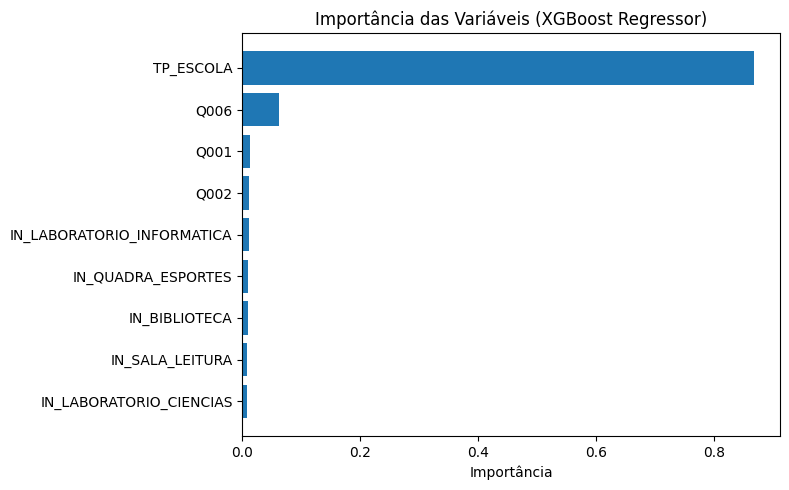

In [14]:
# 1. Importações
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 2. Variáveis do modelo
model_vars = [
    'IN_LABORATORIO_CIENCIAS', 'IN_BIBLIOTECA', 'IN_QUADRA_ESPORTES',
    'IN_SALA_LEITURA', 'IN_LABORATORIO_INFORMATICA',
    'TP_ESCOLA', 'Q001', 'Q002', 'Q006'
]

# 3. Preparar os dados
df_model = df_final[model_vars + ['NU_NOTA_MT']].dropna()
X = df_model[model_vars]
y = df_model['NU_NOTA_MT']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Treinar o modelo
xgb_model = XGBRegressor(random_state=42, verbosity=0)
xgb_model.fit(X_train, y_train)

# 5. Obter importância das variáveis
importances = xgb_model.feature_importances_
feature_names = X_train.columns
importances_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
importances_df = importances_df.sort_values(by='importance', ascending=False)

# 6. Visualizar como tabela
print("📊 Importância das variáveis segundo o XGBoost Regressor:")
print(importances_df)

# 7. Visualizar como gráfico
plt.figure(figsize=(8, 5))
plt.barh(importances_df['feature'], importances_df['importance'])
plt.xlabel("Importância")
plt.title("Importância das Variáveis (XGBoost Regressor)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_train, y_train)
print(classification_report(y_test, model_lr.predict(X_test)))


              precision    recall  f1-score   support

           0       0.64      0.67      0.65    148780
           1       0.69      0.66      0.68    166478

    accuracy                           0.67    315258
   macro avg       0.67      0.67      0.67    315258
weighted avg       0.67      0.67      0.67    315258



In [ ]:
import statsmodels.api as sm
import pandas as pd

notas = ['NU_NOTA_MT', 'NU_NOTA_LC', 'NU_NOTA_CH', 'NU_NOTA_CN', 'NU_NOTA_REDACAO']
resultados_pop = {}

for nota in notas:
    # Garantir que os dados sejam válidos
    df_valid = df_final[['POPULAÇÃO ESTIMADA', nota]].copy()
    df_valid = df_valid.dropna()
    
    # Definir X e y
    X = sm.add_constant(df_valid[['POPULAÇÃO ESTIMADA']])
    y = df_valid[nota]

    # Rodar modelo
    modelo = sm.OLS(y, X).fit()

    resultados_pop[nota] = {
        'R²': round(modelo.rsquared, 4),
        'p-valor_população': round(modelo.pvalues['POPULAÇÃO ESTIMADA'], 4),
        'coef_população': round(modelo.params['POPULAÇÃO ESTIMADA'], 6)
    }

# Resultado
df_resultados_pop = pd.DataFrame(resultados_pop).T
print(df_resultados_pop)


                     R²  p-valor_população  coef_população
NU_NOTA_MT       0.0147                0.0        0.000036
NU_NOTA_LC       0.0185                0.0        0.000020
NU_NOTA_CH       0.0163                0.0        0.000022
NU_NOTA_CN       0.0134                0.0        0.000019
NU_NOTA_REDACAO  0.0102                0.0        0.000044


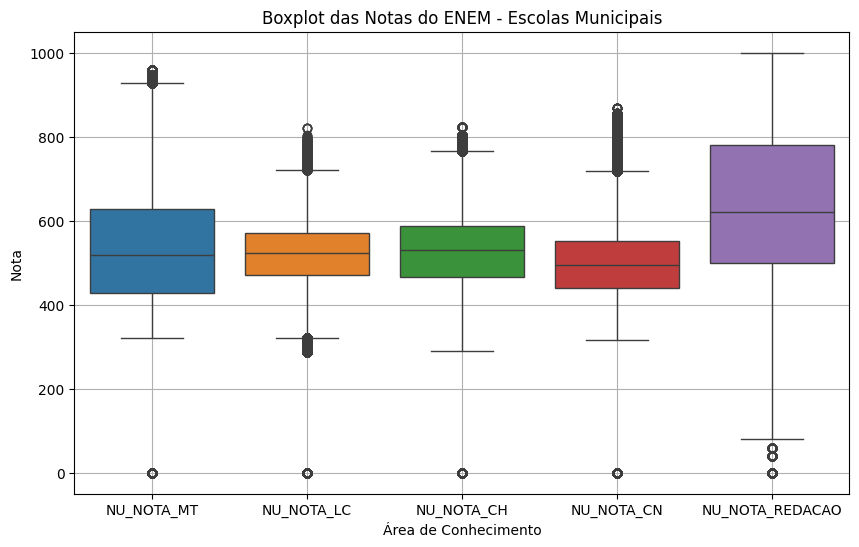

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Selecionar colunas de notas para visualização
notas_cols = ['NU_NOTA_MT', 'NU_NOTA_LC', 'NU_NOTA_CH', 'NU_NOTA_CN', 'NU_NOTA_REDACAO']

# Plotar boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_enem[notas_cols])
plt.title('Boxplot das Notas do ENEM - Escolas Municipais')
plt.ylabel('Nota')
plt.xlabel('Área de Conhecimento')
plt.grid(True)
plt.show()


In [ ]:
# Estatísticas descritivas
df_final[infra_cols].describe().T

nota_cols = ['NU_NOTA_CN',	'NU_NOTA_CH',	'NU_NOTA_LC',	'NU_NOTA_MT',	'NU_NOTA_REDACAO']

df_final[nota_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
NU_NOTA_CN,6899.0,484.364017,46.023678,0.0,452.5000,479.200,510.6500,717.5
NU_NOTA_CH,6912.0,511.242310,49.236471,196.3,477.8875,510.725,542.2125,766.3
NU_NOTA_LC,6912.0,505.961263,41.620356,291.1,477.1875,505.800,533.8000,678.1
NU_NOTA_MT,6899.0,515.948514,83.313927,0.0,451.8500,503.500,567.2000,843.6
NU_NOTA_REDACAO,6912.0,617.301794,122.742252,0.0,540.0000,600.000,680.0000,940.0


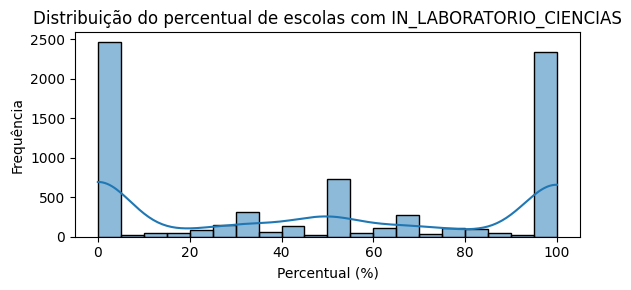

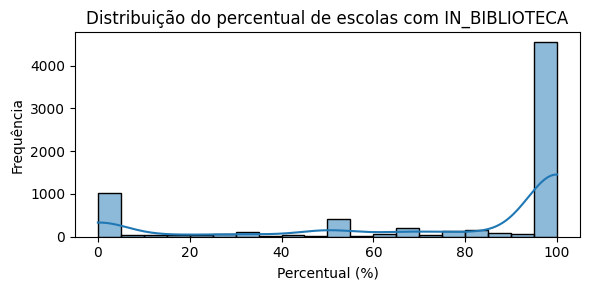

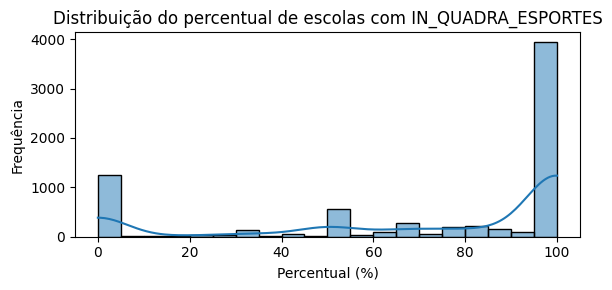

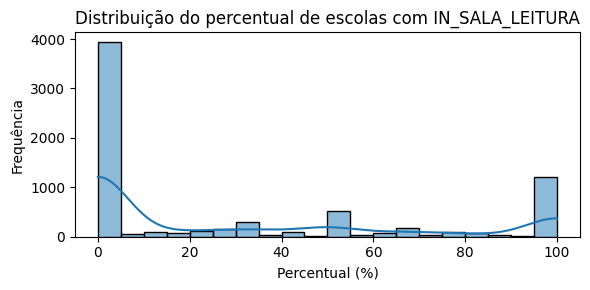

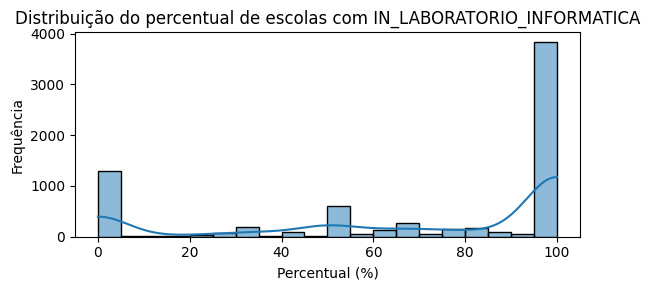

In [ ]:
# Histogramas por variável
import matplotlib.pyplot as plt
import seaborn as sns

for col in infra_cols:
    plt.figure(figsize=(6,3))
    sns.histplot(df_agg[col], kde=True, bins=20)
    plt.title(f'Distribuição do percentual de escolas com {col}')
    plt.xlabel('Percentual (%)')
    plt.ylabel('Frequência')
    plt.tight_layout()
    plt.show()


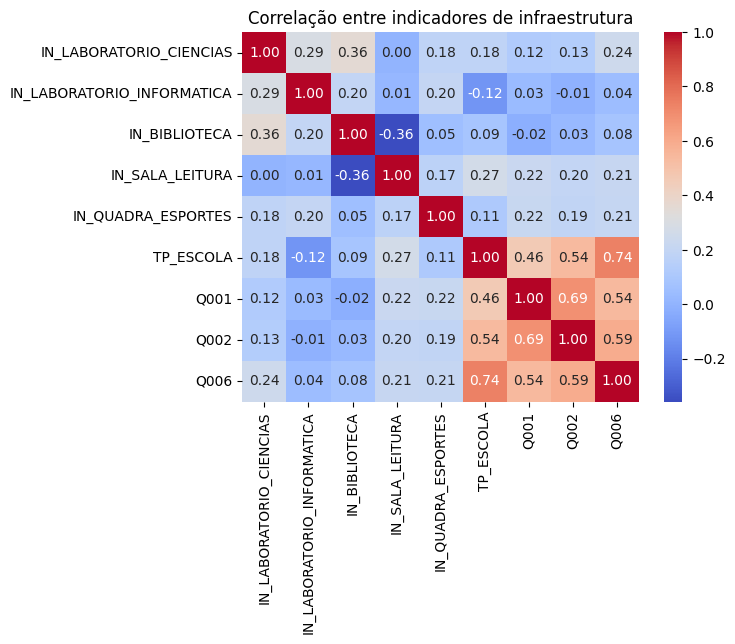

In [10]:
infra_cols = [
    'IN_LABORATORIO_CIENCIAS', 'IN_LABORATORIO_INFORMATICA',
    'IN_BIBLIOTECA', 'IN_SALA_LEITURA', 'IN_QUADRA_ESPORTES',
    'TP_ESCOLA',
    'Q001', 'Q002', 'Q006'
]

corr_infra = df_final[infra_cols].corr()
sns.heatmap(corr_infra, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlação entre indicadores de infraestrutura")
plt.show()


In [ ]:
infra_cols = [
    'IN_LABORATORIO_CIENCIAS', 'IN_LABORATORIO_INFORMATICA',
    'IN_BIBLIOTECA', 'IN_SALA_LEITURA', 'IN_QUADRA_ESPORTES'
]

# Calcular correlação entre variáveis de infraestrutura e nota
df_corr_target = df_final[infra_cols + ['NU_NOTA_MT']].corr()

# Extrair e ordenar
correlations_with_target = df_corr_target['NU_NOTA_MT'].drop('NU_NOTA_MT').sort_values(ascending=False)

# Exibir resultado
print(correlations_with_target)


IN_LABORATORIO_CIENCIAS       0.239288
IN_SALA_LEITURA               0.213798
IN_QUADRA_ESPORTES            0.191740
IN_BIBLIOTECA                 0.097587
IN_LABORATORIO_INFORMATICA    0.061372
Name: NU_NOTA_MT, dtype: float64


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import pandas as pd

# Lista de variáveis explicativas (infraestrutura)
infra_cols = [
    'IN_LABORATORIO_CIENCIAS', 'IN_LABORATORIO_INFORMATICA',
    'IN_BIBLIOTECA', 'IN_SALA_LEITURA', 'IN_QUADRA_ESPORTES', 'TP_ESCOLA', 'POPULAÇÃO ESTIMADA'
]

# Criar o DataFrame com as variáveis explicativas
X = df_final[infra_cols]

# Adiciona a constante (intercepto) para o VIF funcionar corretamente
X_const = add_constant(X)

# Calcular VIF
vif_df = pd.DataFrame()
vif_df["Variável"] = X_const.columns
vif_df["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

# Exibir
print(vif_df)


                     Variável        VIF
0                       const  11.264727
1     IN_LABORATORIO_CIENCIAS   1.289245
2  IN_LABORATORIO_INFORMATICA   1.198248
3               IN_BIBLIOTECA   1.405892
4             IN_SALA_LEITURA   1.339687
5          IN_QUADRA_ESPORTES   1.099001
6                   TP_ESCOLA   1.212303
7          POPULAÇÃO ESTIMADA   1.015896


In [ ]:
# Eliminar linhas com valores ausentes
df_model = df_final[infra_cols + ['NU_NOTA_MT']].dropna()

# Recriar X e y
X = sm.add_constant(df_model[infra_cols])
y = df_model['NU_NOTA_MT']

# Rodar regressão de novo
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:             NU_NOTA_MT   R-squared:                       0.475
Model:                            OLS   Adj. R-squared:                  0.475
Method:                 Least Squares   F-statistic:                     890.8
Date:                Tue, 22 Jul 2025   Prob (F-statistic):               0.00
Time:                        14:29:59   Log-Likelihood:                -38077.
No. Observations:                6899   AIC:                         7.617e+04
Df Residuals:                    6891   BIC:                         7.623e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

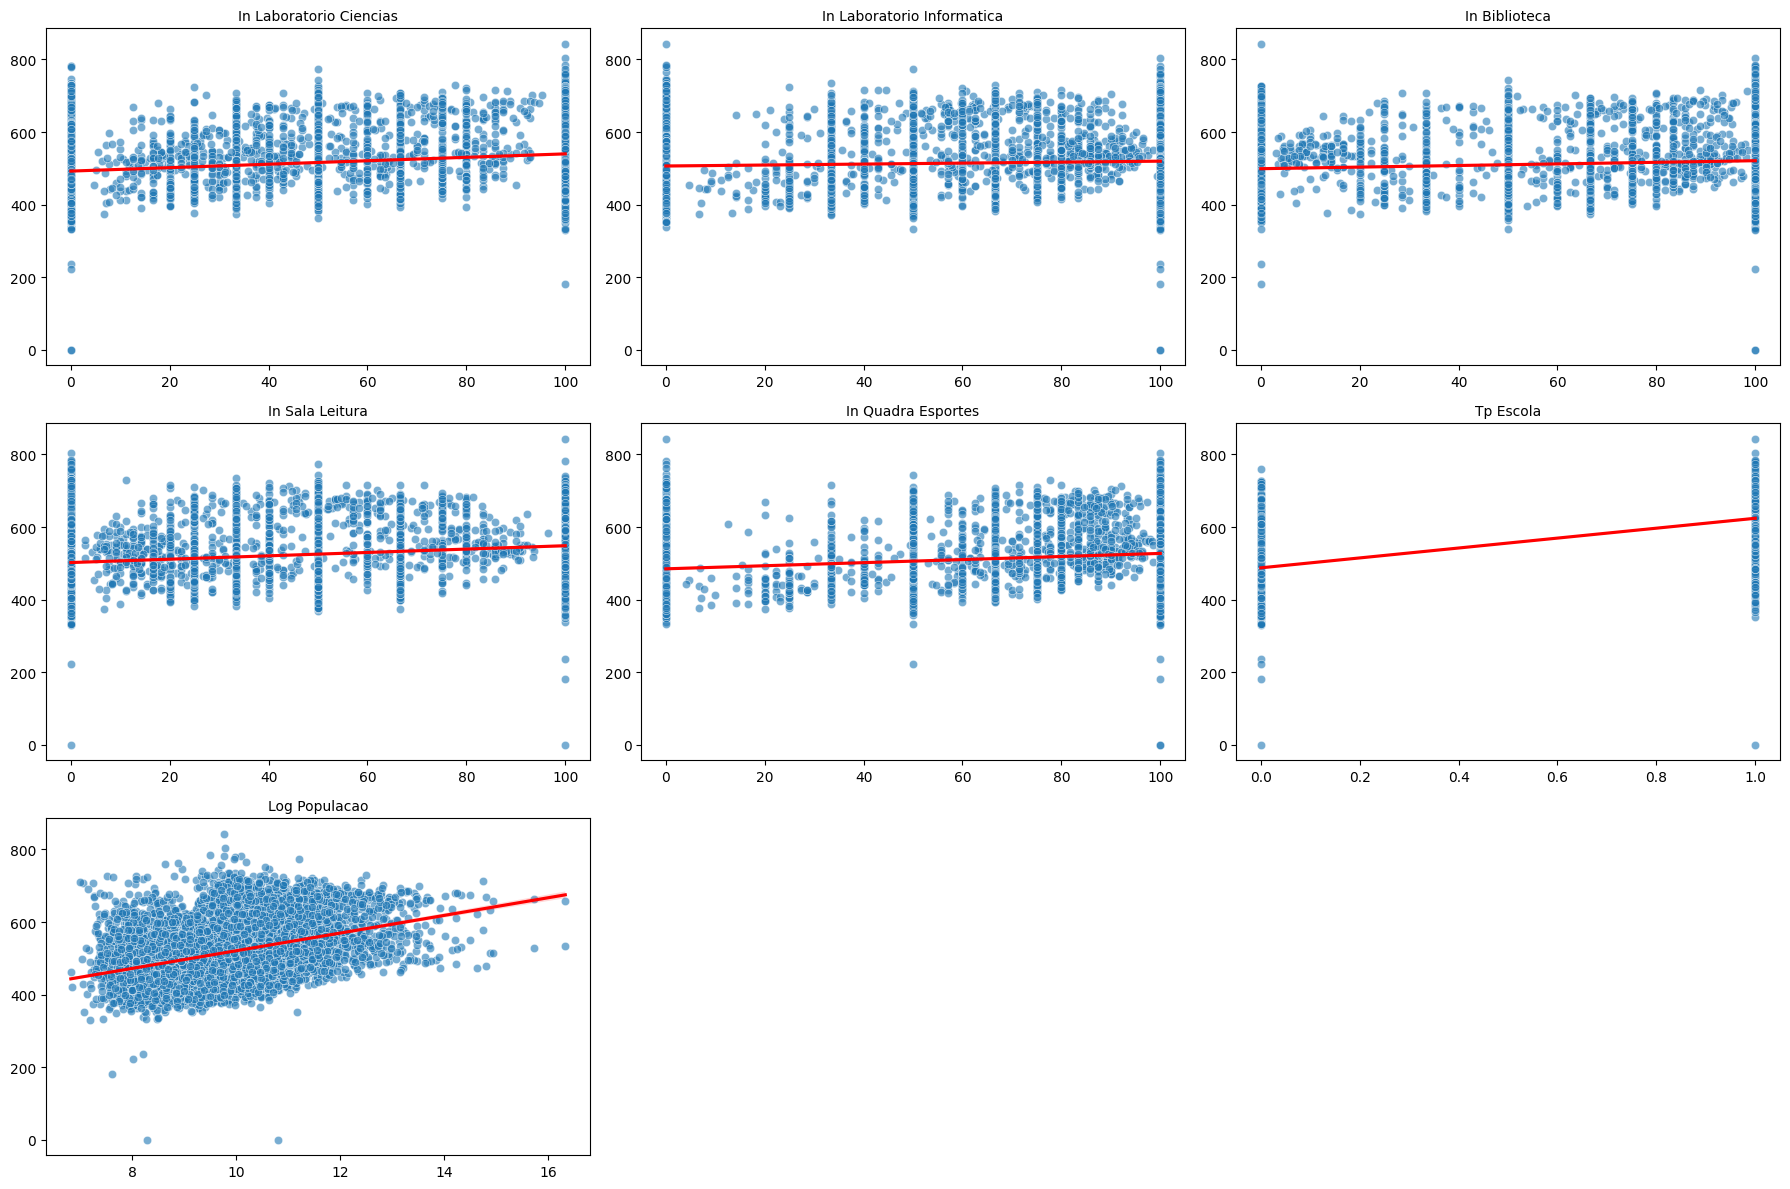

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df_final['LOG_POPULACAO'] = np.log1p(df_final['POPULAÇÃO ESTIMADA'])

# Lista de variáveis explicativas (incluindo população)
infra_cols = [
    'IN_LABORATORIO_CIENCIAS', 'IN_LABORATORIO_INFORMATICA',
    'IN_BIBLIOTECA', 'IN_SALA_LEITURA', 'IN_QUADRA_ESPORTES',
    'TP_ESCOLA', 'LOG_POPULACAO'
]

# Garantir base limpa
df_model = df_final[infra_cols + ['NU_NOTA_MT']].dropna()

# Criar subplots
plt.figure(figsize=(18, 12))

for i, col in enumerate(infra_cols, 1):
    plt.subplot(3, 3, i)
    sns.scatterplot(data=df_model, x=col, y='NU_NOTA_MT', alpha=0.6)
    sns.regplot(data=df_model, x=col, y='NU_NOTA_MT', scatter=False, color='red')
    plt.title(col.replace('_', ' ').title(), fontsize=10)
    plt.xlabel('')
    plt.ylabel('')

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split

infra_cols = [
    'IN_LABORATORIO_CIENCIAS', 'IN_LABORATORIO_INFORMATICA',
    'IN_BIBLIOTECA', 'IN_SALA_LEITURA', 'IN_QUADRA_ESPORTES',
    'TP_ESCOLA', 'LOG_POPULACAO'
]

X = df_final[infra_cols]
y = df_final['NU_NOTA_MT']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
import statsmodels.api as sm

# Seleção de variáveis explicativas (X)
X = df_enem_model[[
    'PAI_SUPERIOR_COMPLETO', 'PAI_FUNDAMENTAL_INCOMPLETO',
    'MAE_SUPERIOR_COMPLETO', 'MAE_FUNDAMENTAL_INCOMPLETO',
    'RENDA_MENOR_1K', 'RENDA_MENOR_2K',
    'RENDA_MENOR_4K', 'RENDA_MAIOR_4K',
    'RACA_BRANCA', 'RACA_PRETA_PARDA', 'RACA_INDIGENA'
]]

# Variável resposta (Y): nota média de matemática por município
y = df_enem_model['NU_NOTA_MT']

# Adiciona constante para o modelo (intercepto)
X = sm.add_constant(X)

# Modelo de regressão linear
modelo = sm.OLS(y, X).fit()

# Resumo do modelo
print(modelo.summary())


                            OLS Regression Results                            
Dep. Variable:             NU_NOTA_MT   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                 2.718e+04
Date:                Fri, 25 Jul 2025   Prob (F-statistic):               0.00
Time:                        11:18:57   Log-Likelihood:            -6.4641e+06
No. Observations:             1050858   AIC:                         1.293e+07
Df Residuals:                 1050846   BIC:                         1.293e+07
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [ ]:
print(f"R²: {modelo.rsquared:.3f}")
print(f"Observações: {int(modelo.nobs)}")
print(f"F-statistic: {modelo.fvalue:.1f}")
print(f"p-valor do modelo: {modelo.f_pvalue:.4f}")


R²: 0.221
Observações: 1050858
F-statistic: 27179.3
p-valor do modelo: 0.0000


In [ ]:
resumo = pd.DataFrame({
    'Variável': modelo.params.index,
    'Coeficiente': modelo.params.values,
    'p-valor': modelo.pvalues.values
})
resumo['Significância'] = resumo['p-valor'].apply(
    lambda p: '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'ns'
)

# Excluir constante
resumo = resumo[resumo['Variável'] != 'const']

# Visualizar
print(resumo)


                      Variável   Coeficiente        p-valor Significância
1        PAI_SUPERIOR_COMPLETO -1.775038e+01   0.000000e+00           ***
2   PAI_FUNDAMENTAL_INCOMPLETO -2.096020e+01   0.000000e+00           ***
3        MAE_SUPERIOR_COMPLETO -2.290194e+01  1.568068e-292           ***
4   MAE_FUNDAMENTAL_INCOMPLETO -2.090525e+01   0.000000e+00           ***
5               RENDA_MENOR_1K -2.836656e+01   0.000000e+00           ***
6               RENDA_MENOR_2K -2.509499e+01   0.000000e+00           ***
7               RENDA_MENOR_4K -1.703540e+12   6.177869e-01            ns
8               RENDA_MAIOR_4K -1.703540e+12   6.177869e-01            ns
9                  RACA_BRANCA  1.540742e+01  1.604864e-105           ***
10            RACA_PRETA_PARDA -1.464571e+01   1.088930e-96           ***
11               RACA_INDIGENA -4.167650e+01  2.717814e-138           ***


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred_bin = (xgb_model.predict_proba(X_test)[:, 1] >= 0.5).astype(int)
print(confusion_matrix(y_test, y_pred_bin))
print(classification_report(y_test, y_pred_bin))


[[184150 120434]
 [ 78293 267176]]
              precision    recall  f1-score   support

           0       0.70      0.60      0.65    304584
           1       0.69      0.77      0.73    345469

    accuracy                           0.69    650053
   macro avg       0.70      0.69      0.69    650053
weighted avg       0.70      0.69      0.69    650053



c:\Users\pedro\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


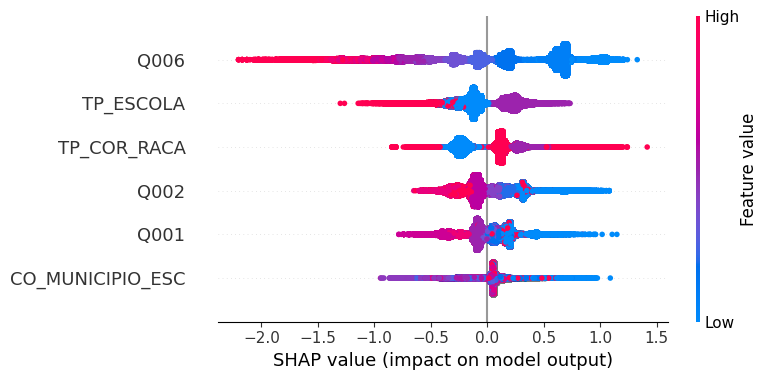

In [ ]:


import shap

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

